In [1]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import seaborn as sns
import time
from torchsummary import summary

In [2]:
import os

print("Folders inside extracted data:")
print(os.listdir("./deep_learning/reduced_data_20k/reduced_data_20k"))

Folders inside extracted data:
['.amlignore', '.amlignore.amltmp', '.DS_Store', 'test', 'train', 'val']


In [3]:
main_path = './deep_learning/reduced_data_20k/reduced_data_20k'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'val')
test_dir = os.path.join(main_path, 'test')

In [4]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['.amlignore', '.amlignore.amltmp', '.DS_Store', 'fake', 'real']


In [5]:
img_size = 128
batch_size = 32

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

In [6]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(valid_dir, transform=val_test_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

print("Original Train size:", len(train_data))
print("Original Val size:", len(val_data))
print("Original Test size:", len(test_data))

Original Train size: 14000
Original Val size: 3000
Original Test size: 3000


In [7]:
from torch.utils.data import Subset
import random

def balance_subset(dataset, max_per_class):
    class_indices = {cls: [] for cls in dataset.class_to_idx.keys()}

    for idx, (_, label) in enumerate(dataset.samples):
        class_name = dataset.classes[label]
        class_indices[class_name].append(idx)

    selected_indices = []
    for cls, indices in class_indices.items():
        selected = random.sample(indices, min(len(indices), max_per_class))
        selected_indices.extend(selected)

    return Subset(dataset, selected_indices)

# Reduce: 2.5K total per split → 1.25K per class
train_data = balance_subset(train_data, max_per_class=1250)
val_data = balance_subset(val_data, max_per_class=625)
test_data = balance_subset(test_data, max_per_class=625)

print("Train size:", len(train_data))
print("Val size:", len(val_data))
print("Test size:", len(test_data))


Train size: 2500
Val size: 1250
Test size: 1250


In [8]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

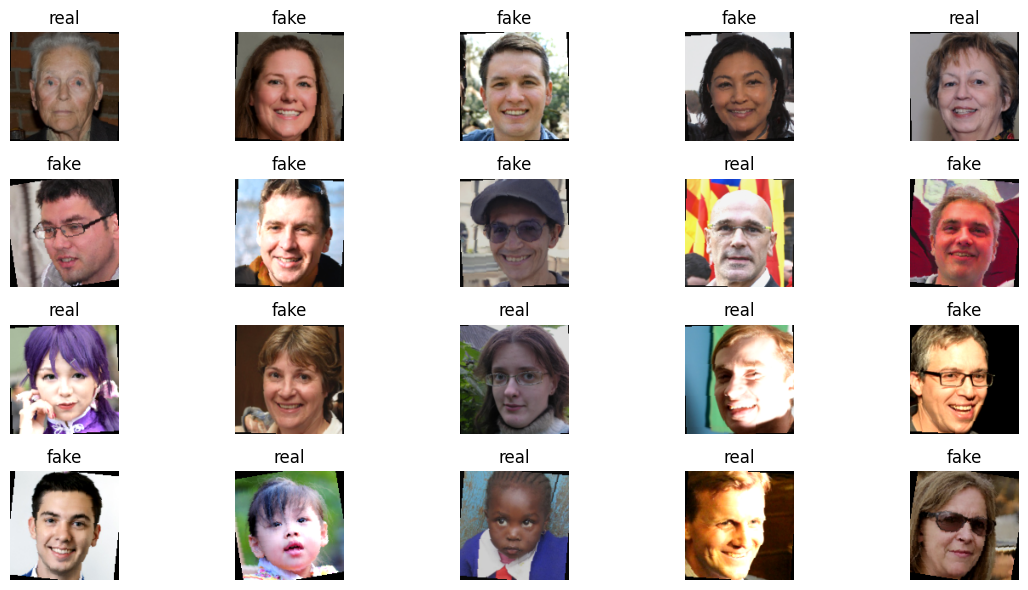

In [9]:
def plot_random_images(data_loader, class_names):
    

    images, labels = next(iter(data_loader))

    plt.figure(figsize=(12, 6))
    for i in range(min(20, len(images))):
        plt.subplot(4, 5, i + 1)
        img = images[i].permute(1, 2, 0) 
        img = torch.clamp(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_names[labels[i]])
    plt.tight_layout()
    plt.show()

plot_random_images(train_loader, class_names=train_data.dataset.classes)

In [10]:
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)  # [batch_size, channels, height, width]
print("One sample shape:", images[0].shape)
print("Data type:", images.dtype)

Image batch shape: torch.Size([32, 3, 128, 128])
One sample shape: torch.Size([3, 128, 128])
Data type: torch.float32


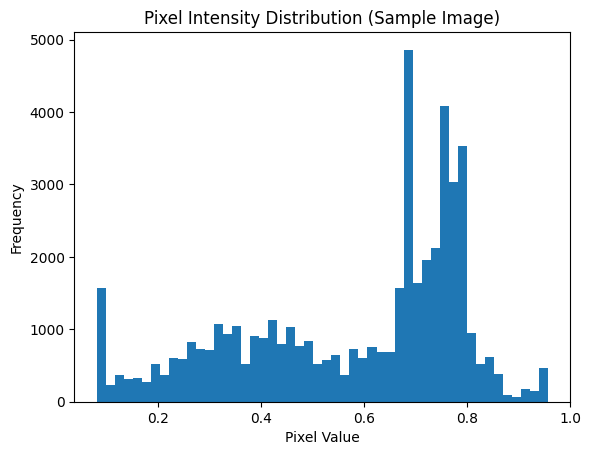

In [11]:
img_flat = images[0].numpy().flatten()
plt.hist(img_flat, bins=50)
plt.title("Pixel Intensity Distribution (Sample Image)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

🧠 What This Tells You
✅ 1. Pixel values are correctly normalized
The X-axis ranges from 0.0 to 1.0 → confirms ToTensor() is working

Most pixel values are below 0.3, with a sharp peak near 0 → meaning the image is relatively dark or has low brightness

✅ 2. Dataset has natural variation
The histogram has a healthy spread of pixel values — it’s not all black/white

This implies images contain textural and shading detail, which is important for a CNN to learn from

✅ 3. You likely don’t need additional normalization (yet)
Since your values are already in the [0, 1] range, training with a simple CNN will work fine.

If you later use a pretrained model like ResNet, you’ll need to use transforms.Normalize(...) with ImageNet mean and std values:

python
Copy
Edit
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
✍️ How to Write This in Your Report:
Pixel Intensity Analysis
We visualized the pixel intensity distribution of a sample image after applying PyTorch’s transforms.ToTensor(). As expected, the values were normalized in the [0, 1] range. The majority of pixel values fell below 0.3, indicating that the image had relatively low brightness. The distribution confirmed a good range of intensity variation, suggesting sufficient visual features for training convolutional neural networks.


# simpleNN

In [12]:
hyperparameter_combos = [
    {"lr": 0.001, "dropout": 0.5, "optimizer": "Adam"},
    {"lr": 0.0005, "dropout": 0.3, "optimizer": "SGD"},
    {"lr": 0.01, "dropout": 0.5, "optimizer": "Adam"},
]

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * (img_size // 4) * (img_size // 4), 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # Output: [B, 32, H/2, W/2]
        x = self.pool(F.relu(self.conv2(x)))   # Output: [B, 64, H/4, W/4]
        x = x.view(x.size(0), -1)              # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))         # Output range: (0, 1)
        return x

In [14]:
# Training function
def train_model(model, optimizer, criterion, epochs, train_loader, val_loader):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        avg_train_loss = train_loss / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.float().unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                predicted = (outputs > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        avg_val_loss = val_loss / val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [15]:
results = []
epochs = 10
best_val_acc = 0.0
img_size = 128

for i, hp in enumerate(hyperparameter_combos, 1):
    print(f"\nTraining Model - Combo {i}")
    print(f"Learning rate: {hp['lr']}, Dropout: {hp['dropout']}, Optimizer: {hp['optimizer']}")

    model = SimpleCNN(dropout_rate=hp["dropout"]) 
    summary(model, input_size=(3, 128, 128))
    criterion = nn.BCELoss()

    if hp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=hp["lr"])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=hp["lr"], momentum=0.9)

    # Time starts here
    start_time = time.time()

    history = train_model(model, optimizer, criterion, epochs, train_loader, val_loader)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for Combo {i}: {elapsed_time / 60:.2f} minutes")

    val_acc = history["val_acc"][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_simplecnn.pth")
        print(f"Saved best simplenn model at Combo {i} with Val Acc: {val_acc:.4f}")

    results.append({
        "combo": i,
        "hyperparams": hp,
        "history": history,
        "model": model
    })



Training Model - Combo 1
Learning rate: 0.001, Dropout: 0.5, Optimizer: Adam
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Linear-5                  [-1, 128]       8,388,736
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
Total params: 8,408,257
Trainable params: 8,408,257
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 7.50
Params size (MB): 32.07
Estimated Total Size (MB): 39.76
----------------------------------------------------------------
Epoch 1: Train Acc: 0.

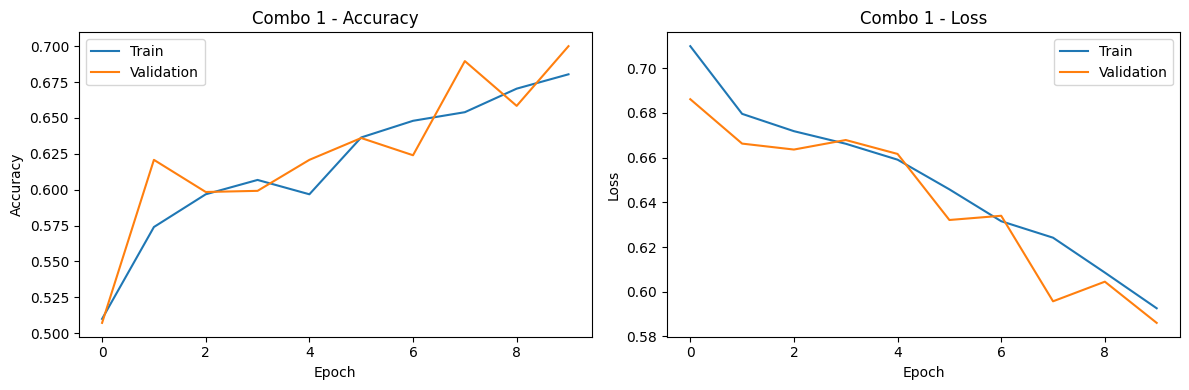

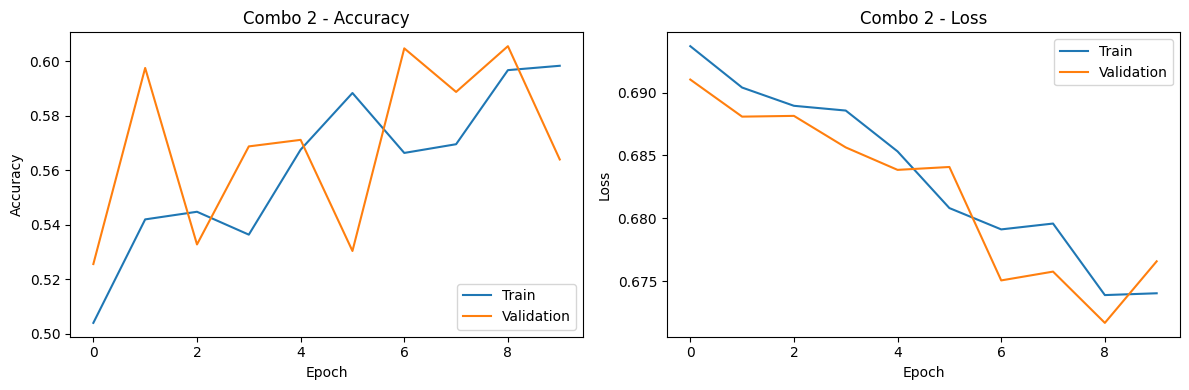

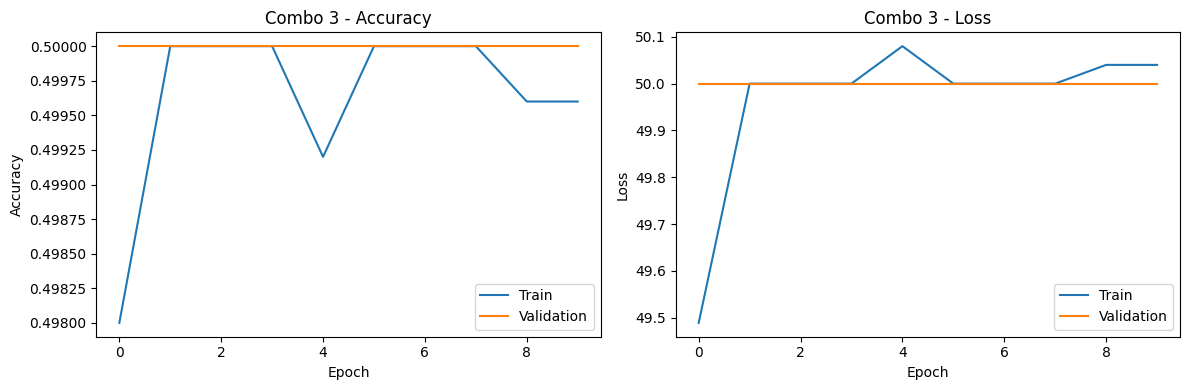

In [16]:
import matplotlib.pyplot as plt

def plot_learning_curves(results):
    for result in results:
        combo = result["combo"]
        history = result["history"]

        plt.figure(figsize=(12, 4))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history["train_acc"], label="Train")
        plt.plot(history["val_acc"], label="Validation")
        plt.title(f"Combo {combo} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history["train_loss"], label="Train")
        plt.plot(history["val_loss"], label="Validation")
        plt.title(f"Combo {combo} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot all 3 combos
plot_learning_curves(results)

In [17]:
import pandas as pd

summary_data = []

for result in results:
    history = result["history"]
    final_train_acc = history["train_acc"][-1]
    final_val_acc = history["val_acc"][-1]
    final_train_loss = history["train_loss"][-1]
    final_val_loss = history["val_loss"][-1]

    row = {
        "Combo": result["combo"],
        "Learning Rate": result["hyperparams"]["lr"],
        "Dropout": result["hyperparams"]["dropout"],
        "Optimizer": result["hyperparams"]["optimizer"],
        "Train Accuracy": round(final_train_acc, 4),
        "Val Accuracy": round(final_val_acc, 4),
        "Train Loss": round(final_train_loss, 4),
        "Val Loss": round(final_val_loss, 4)
    }
    summary_data.append(row)

df_results = pd.DataFrame(summary_data)
df_results.sort_values("Val Accuracy", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)

df_results

,Combo,Learning Rate,Dropout,Optimizer,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,1,0.0010,0.5,Adam,0.6804,0.700,0.5926,0.5861
1,2,0.0005,0.3,SGD,0.5984,0.564,0.6740,0.6766
2,3,0.0100,0.5,Adam,0.4996,0.500,50.0400,50.0000


**testing**

Accuracy:  0.6936
Precision: 0.6990
Recall:    0.6800
F1 Score:  0.6894


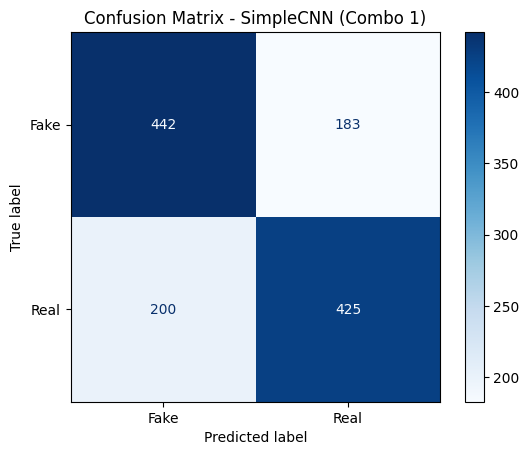

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load best model (SimpleCNN Combo 1 is at index 0)
best_simplecnn = results[0]["model"]
best_simplecnn.eval()  # Set to evaluation mode

# Run on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_simplecnn(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.unsqueeze(1).cpu().numpy())

# Flatten arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print results
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SimpleCNN (Combo 1)")
plt.show()

# VGGnet16

In [19]:
from torchvision import models

def get_vgg16_model(dropout_rate=0.5):
    model = models.vgg16(pretrained=True)
    
    # Freeze the convolutional base
    for param in model.features.parameters():
        param.requires_grad = False

    # Replace classifier with a custom binary classifier
    model.classifier = nn.Sequential(
        nn.Linear(25088, 4096),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(4096, 1024),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(1024, 1),
        nn.Sigmoid()
    )

    return model

In [20]:
vgg_hyperparams = [
    {"lr": 0.0001, "dropout": 0.3, "optimizer": "Adam"},
    {"lr": 0.0005, "dropout": 0.4, "optimizer": "SGD"},
    {"lr": 0.00001, "dropout": 0.5, "optimizer": "Adam"}
]

In [21]:
vgg_results = []
epochs = 10
best_val_acc = 0.0

for i, hp in enumerate(vgg_hyperparams, 1):
    print(f"\nTraining VGG16 - Combo {i}")
    print(f"Learning rate: {hp['lr']}, Dropout: {hp['dropout']}, Optimizer: {hp['optimizer']}")

    model = get_vgg16_model(dropout_rate=hp["dropout"])
    summary(model, input_size=(3, 128, 128))

    criterion = nn.BCELoss()

    if hp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=hp["lr"])
    else:
        optimizer = torch.optim.SGD(model.classifier.parameters(), lr=hp["lr"], momentum=0.9)

    # Time starts here
    start_time = time.time() 

    history = train_model(model, optimizer, criterion, epochs, train_loader, val_loader)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for Combo {i}: {elapsed_time / 60:.2f} minutes")

    val_acc = history["val_acc"][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg16.pth")
        print(f"Saved best vgg16 model at Combo {i} with Val Acc: {val_acc:.4f}")


    vgg_results.append({
        "combo": i,
        "hyperparams": hp,
        "history": history,
        "model": model
    })

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

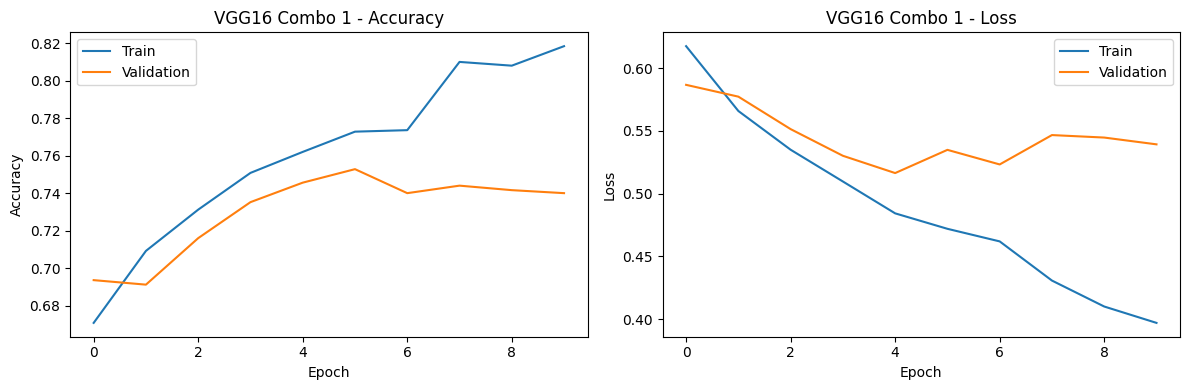

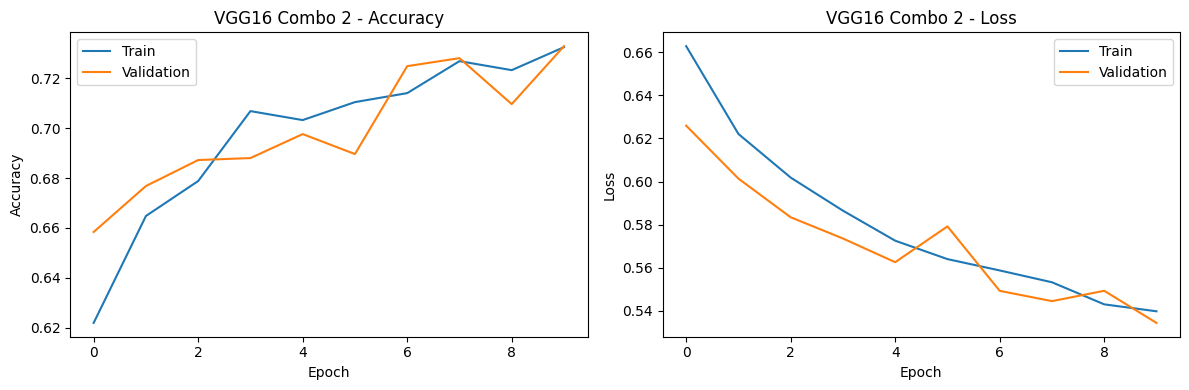

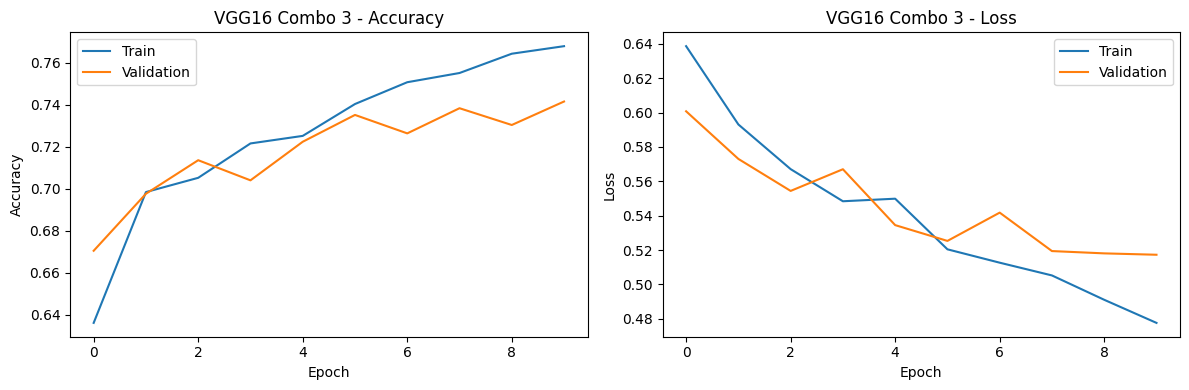

In [22]:
def plot_learning_curves(results, model_name="Model"):
    for result in results:
        combo = result["combo"]
        history = result["history"]

        plt.figure(figsize=(12, 4))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history["train_acc"], label="Train")
        plt.plot(history["val_acc"], label="Validation")
        plt.title(f"{model_name} Combo {combo} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history["train_loss"], label="Train")
        plt.plot(history["val_loss"], label="Validation")
        plt.title(f"{model_name} Combo {combo} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot for VGG16
plot_learning_curves(vgg_results, model_name="VGG16")


In [23]:
import pandas as pd

vgg_summary = []

for result in vgg_results:
    history = result["history"]
    final_train_acc = history["train_acc"][-1]
    final_val_acc = history["val_acc"][-1]
    final_train_loss = history["train_loss"][-1]
    final_val_loss = history["val_loss"][-1]

    row = {
        "Combo": result["combo"],
        "Learning Rate": result["hyperparams"]["lr"],
        "Dropout": result["hyperparams"]["dropout"],
        "Optimizer": result["hyperparams"]["optimizer"],
        "Train Accuracy": round(final_train_acc, 4),
        "Val Accuracy": round(final_val_acc, 4),
        "Train Loss": round(final_train_loss, 4),
        "Val Loss": round(final_val_loss, 4)
    }
    vgg_summary.append(row)

vgg_df = pd.DataFrame(vgg_summary)
vgg_df.sort_values("Val Accuracy", ascending=False, inplace=True)
vgg_df.reset_index(drop=True, inplace=True)

vgg_df


,Combo,Learning Rate,Dropout,Optimizer,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,3,0.00001,0.5,Adam,0.7680,0.7416,0.4776,0.5172
1,1,0.00010,0.3,Adam,0.8184,0.7400,0.3970,0.5392
2,2,0.00050,0.4,SGD,0.7324,0.7328,0.5398,0.5344


Accuracy:  0.7256
Precision: 0.7289
Recall:    0.7184
F1 Score:  0.7236


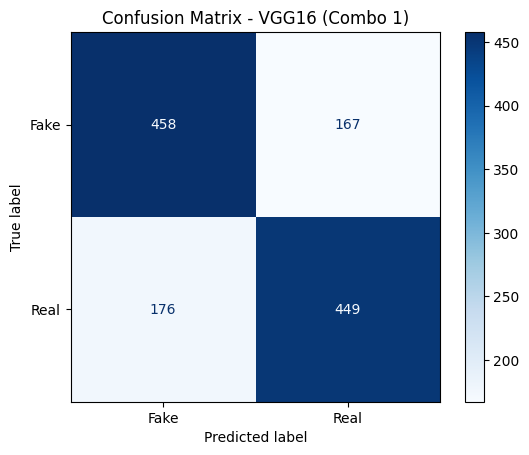

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load best VGG16 model from Combo 1 (index 0)
best_vgg16 = vgg_results[0]["model"]
best_vgg16.eval()

# Run on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_vgg16(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.unsqueeze(1).cpu().numpy())

# Flatten arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print results
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - VGG16 (Combo 1)")
plt.show()

# RESnet18

In [25]:
from torchvision import models

def get_resnet18_model():
    model = models.resnet18(pretrained=True)

    # Freeze all layers except the last
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze only the final FC layer
    for param in model.fc.parameters():
        param.requires_grad = True

    # Replace the fully connected layer for binary classification
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1),
        nn.Sigmoid()
    )

    return model


In [26]:
resnet_hyperparams = [
    {"lr": 0.0001, "optimizer": "Adam"},
    {"lr": 0.001, "optimizer": "SGD"},
    {"lr": 0.0005, "optimizer": "Adam"}
]

In [27]:
resnet_results = []
epochs = 10
best_val_acc = 0.0

for i, hp in enumerate(resnet_hyperparams, 1):
    print(f"\nTraining ResNet18 - Combo {i}")
    print(f"Learning Rate: {hp['lr']}, Optimizer: {hp['optimizer']}")

    model = get_resnet18_model()
    summary(model, input_size=(3, 128, 128))
    criterion = nn.BCELoss()

    if hp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.fc.parameters(), lr=hp["lr"])
    else:
        optimizer = torch.optim.SGD(model.fc.parameters(), lr=hp["lr"], momentum=0.9)

    
    start_time = time.time() 

    history = train_model(model, optimizer, criterion, epochs, train_loader, val_loader)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for Combo {i}: {elapsed_time / 60:.2f} minutes")

    val_acc = history["val_acc"][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet18.pth")
        print(f"Saved best ResNet18 model at Combo {i} with Val Acc: {val_acc:.4f}")


    resnet_results.append({
        "combo": i,
        "hyperparams": hp,
        "history": history,
        "model": model
    })


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc: 0.5348, Val Acc: 0.5672
Epoch 2: Train Acc: 0.5656, Val Acc: 0.5768
Epoch 3: Train Acc: 0.5924, Val Acc: 0.5952
Epoch 4: Train Acc: 0.6024, Val Acc: 0.6120
Epoch 5: Train Acc: 0.6264, Val Acc: 0.6256
Epoch 6: Train Acc: 0.6296, Val Acc: 0.6424
Epoch 7: Train Acc: 0.6440, Val Acc: 0.6384
Epoch 8: Train Acc: 0.6444, Val Acc: 0.6536
Epoch 9: Train Acc: 0.6524, Val Acc: 0.6672
Epoch 10: Train Acc: 0.6704, Val Acc: 0.6552
Training time for Combo 1: 14.39 minutes
Saved best ResNet18 model at Combo 1 with Val Acc: 0.6552

Training ResNet18 - Combo 2
Learning Rate: 0.001, Optimizer: SGD
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
         

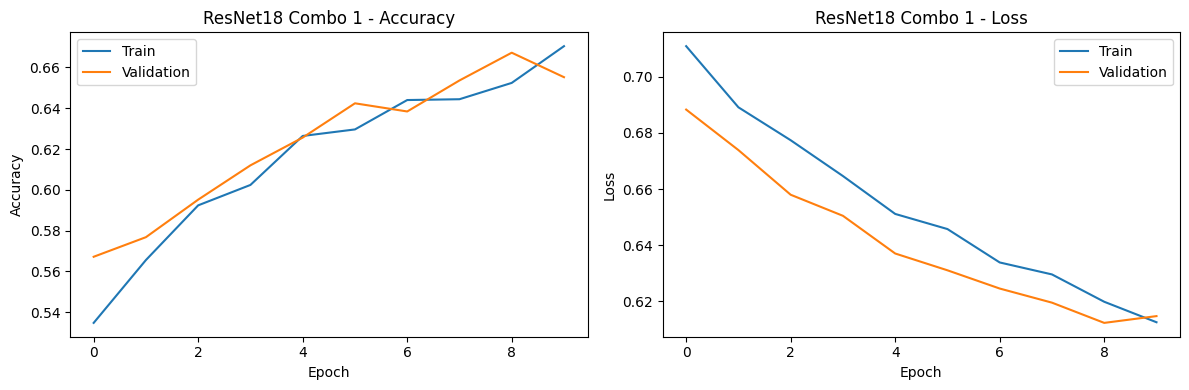

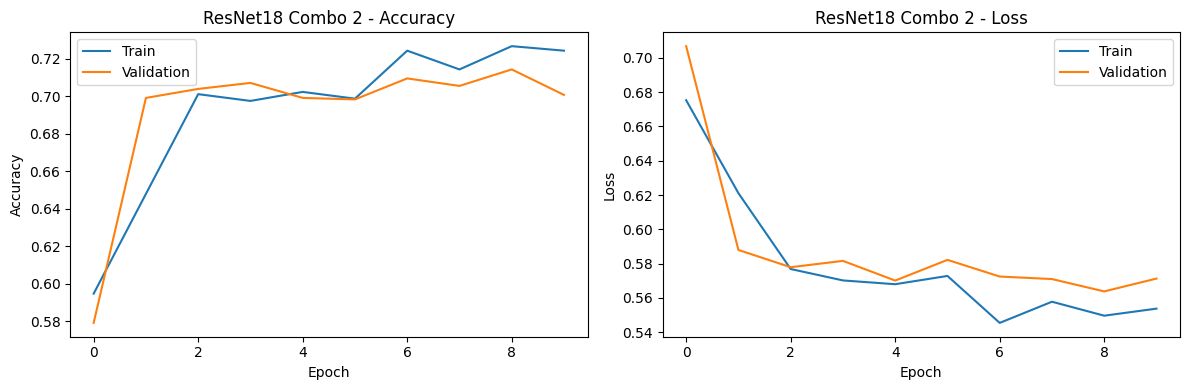

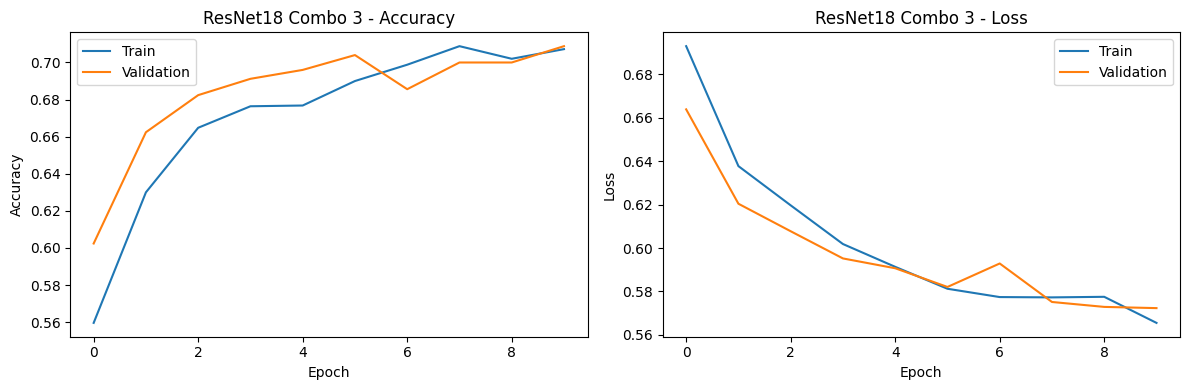

In [28]:
import matplotlib.pyplot as plt

def plot_learning_curves(results, model_name="Model"):
    for result in results:
        combo = result["combo"]
        history = result["history"]

        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history["train_acc"], label="Train")
        plt.plot(history["val_acc"], label="Validation")
        plt.title(f"{model_name} Combo {combo} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history["train_loss"], label="Train")
        plt.plot(history["val_loss"], label="Validation")
        plt.title(f"{model_name} Combo {combo} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot learning curves for ResNet18
plot_learning_curves(resnet_results, model_name="ResNet18")


In [29]:
import pandas as pd

resnet_summary = []

for result in resnet_results:
    history = result["history"]
    final_train_acc = history["train_acc"][-1]
    final_val_acc = history["val_acc"][-1]
    final_train_loss = history["train_loss"][-1]
    final_val_loss = history["val_loss"][-1]

    row = {
        "Combo": result["combo"],
        "Learning Rate": result["hyperparams"]["lr"],
        "Optimizer": result["hyperparams"]["optimizer"],
        "Train Accuracy": round(final_train_acc, 4),
        "Val Accuracy": round(final_val_acc, 4),
        "Train Loss": round(final_train_loss, 4),
        "Val Loss": round(final_val_loss, 4)
    }
    resnet_summary.append(row)

resnet_df = pd.DataFrame(resnet_summary)
resnet_df.sort_values("Val Accuracy", ascending=False, inplace=True)
resnet_df.reset_index(drop=True, inplace=True)

resnet_df


,Combo,Learning Rate,Optimizer,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,3,0.0005,Adam,0.7072,0.7088,0.5655,0.5723
1,2,0.0010,SGD,0.7244,0.7008,0.5537,0.5713
2,1,0.0001,Adam,0.6704,0.6552,0.6124,0.6146


Accuracy:  0.6992
Precision: 0.6766
Recall:    0.7632
F1 Score:  0.7173


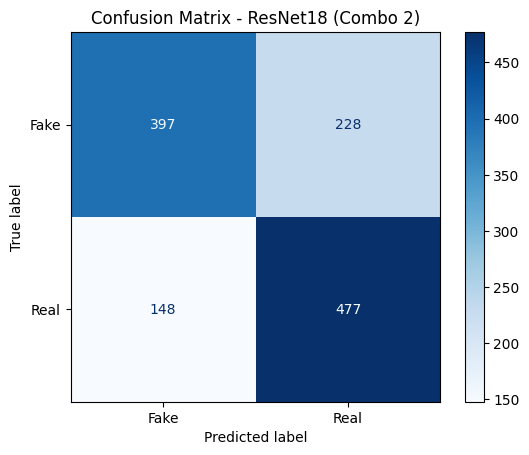

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load best ResNet18 model from Combo 2 (index 1)
best_resnet = resnet_results[1]["model"]
best_resnet.eval()

# Run on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_resnet(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.unsqueeze(1).cpu().numpy())

# Flatten arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print results
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - ResNet18 (Combo 2)")
plt.show()

# DensNet

In [31]:
%%capture
!pip install torchinfo

In [32]:
from torchinfo import summary

In [33]:
from torchvision import models
import torch.nn as nn

def get_densenet121_model():
    model = models.densenet121(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze classifier layer
    for param in model.classifier.parameters():
        param.requires_grad = True

    # Replace classifier
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier.in_features, 1),
        nn.Sigmoid()
    )

    return model

In [34]:
densenet_hyperparams = [
    {"lr": 0.0001, "optimizer": "Adam"},
    {"lr": 0.0005, "optimizer": "SGD"},
    {"lr": 0.0003, "optimizer": "Adam"}
]

In [35]:
def safe_summary(model, input_size):
    from torchinfo import summary
    try:
        summary(model, input_size=input_size)
    except Exception as e:
        print(f"Model summary failed:", e)

In [36]:

densenet_results = []
epochs = 10
best_val_acc = 0.0

for i, hp in enumerate(densenet_hyperparams, 1):
    print(f"\nTraining DenseNet121 - Combo {i}")
    print(f"Learning Rate: {hp['lr']}, Optimizer: {hp['optimizer']}")

    model = get_densenet121_model()
    model_summary = summary(model, input_size=(1, 3, 128, 128))
    print(model_summary)

   
    criterion = nn.BCELoss()

    if hp["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=hp["lr"])
    else:
        optimizer = torch.optim.SGD(model.classifier.parameters(), lr=hp["lr"], momentum=0.9)

  
    start_time = time.time() 

    history = train_model(model, optimizer, criterion, epochs, train_loader, val_loader)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time for Combo {i}: {elapsed_time / 60:.2f} minutes")

    val_acc = history["val_acc"][-1]
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_densenet121.pth")
        print(f" Saved best DenseNet121 model at Combo {i} with Val Acc: {val_acc:.4f}")

    densenet_results.append({
        "combo": i,
        "hyperparams": hp,
        "history": history,
        "model": model
    })

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [1, 1]                    --
├─Sequential: 1-1                        [1, 1024, 4, 4]           --
│    └─Conv2d: 2-1                       [1, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                  [1, 64, 64, 64]           (128)
│    └─ReLU: 2-3                         [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                    [1, 64, 32, 32]           --
│    └─_DenseBlock: 2-5                  [1, 256, 32, 32]          --
│    │    └─_DenseLayer: 3-1             [1, 32, 32, 32]           (45,440)
│    │    └─_DenseLayer: 3-2             [1, 32, 32, 32]           (49,600)
│    │    └─_DenseLayer: 3-3             [1, 32, 32, 32]           (53,760)
│    │    └─_DenseLayer: 3-4             [1, 32, 32, 32]           (57,920)
│    │    └─_DenseLayer: 3-5             [1, 32, 32, 32]           (62,080)
│    │    └─_DenseLayer: 3-6             [1, 32

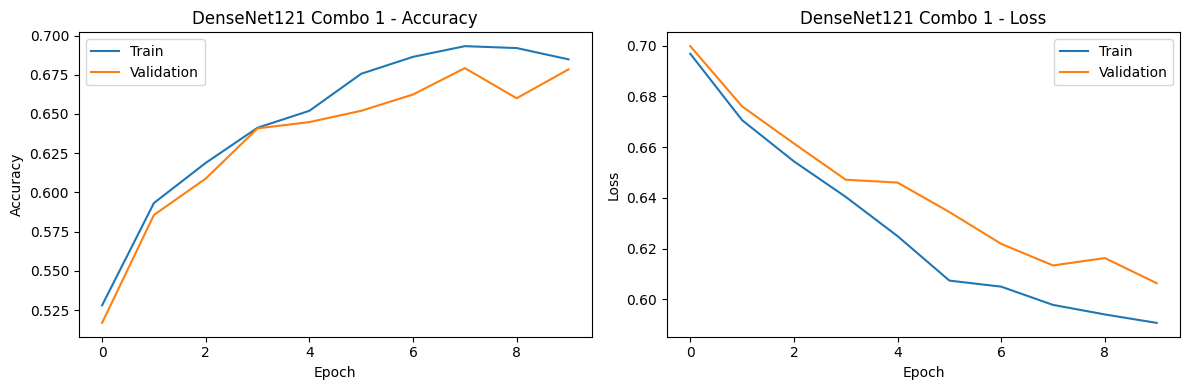

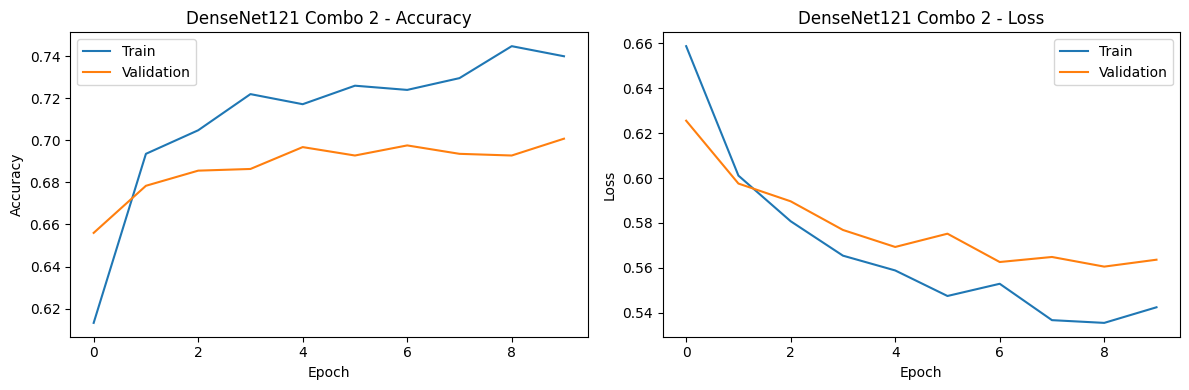

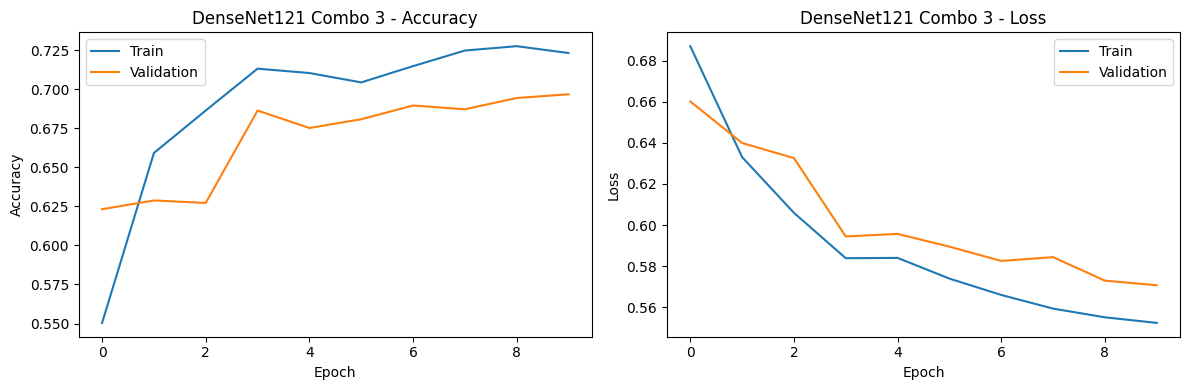

In [37]:
def plot_learning_curves(results, model_name="Model"):
    for result in results:
        combo = result["combo"]
        history = result["history"]

        plt.figure(figsize=(12, 4))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history["train_acc"], label="Train")
        plt.plot(history["val_acc"], label="Validation")
        plt.title(f"{model_name} Combo {combo} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history["train_loss"], label="Train")
        plt.plot(history["val_loss"], label="Validation")
        plt.title(f"{model_name} Combo {combo} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot for DenseNet121
plot_learning_curves(densenet_results, model_name="DenseNet121")


In [38]:
import pandas as pd

densenet_summary = []

for result in densenet_results:
    history = result["history"]
    final_train_acc = history["train_acc"][-1]
    final_val_acc = history["val_acc"][-1]
    final_train_loss = history["train_loss"][-1]
    final_val_loss = history["val_loss"][-1]

    row = {
        "Combo": result["combo"],
        "Learning Rate": result["hyperparams"]["lr"],
        "Optimizer": result["hyperparams"]["optimizer"],
        "Train Accuracy": round(final_train_acc, 4),
        "Val Accuracy": round(final_val_acc, 4),
        "Train Loss": round(final_train_loss, 4),
        "Val Loss": round(final_val_loss, 4)
    }
    densenet_summary.append(row)

densenet_df = pd.DataFrame(densenet_summary)
densenet_df.sort_values("Val Accuracy", ascending=False, inplace=True)
densenet_df.reset_index(drop=True, inplace=True)

densenet_df


,Combo,Learning Rate,Optimizer,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,2,0.0005,SGD,0.7400,0.7008,0.5424,0.5636
1,3,0.0003,Adam,0.7232,0.6968,0.5524,0.5707
2,1,0.0001,Adam,0.6848,0.6784,0.5908,0.6064


Accuracy:  0.7080
Precision: 0.7500
Recall:    0.6240
F1 Score:  0.6812


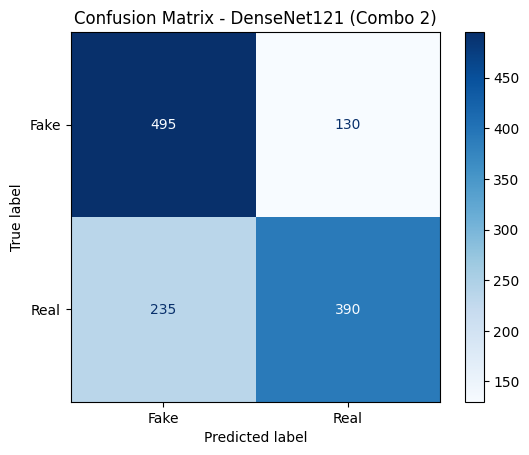

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Load best DenseNet121 model from Combo 2 (index 1)
best_densenet = densenet_results[1]["model"]
best_densenet.eval()

# Run on test set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_densenet(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.unsqueeze(1).cpu().numpy())

# Flatten arrays
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Compute metrics
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Print results
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - DenseNet121 (Combo 2)")
plt.show()


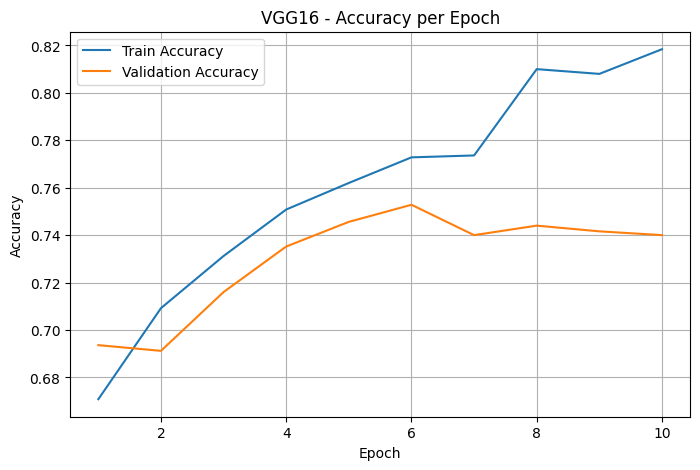

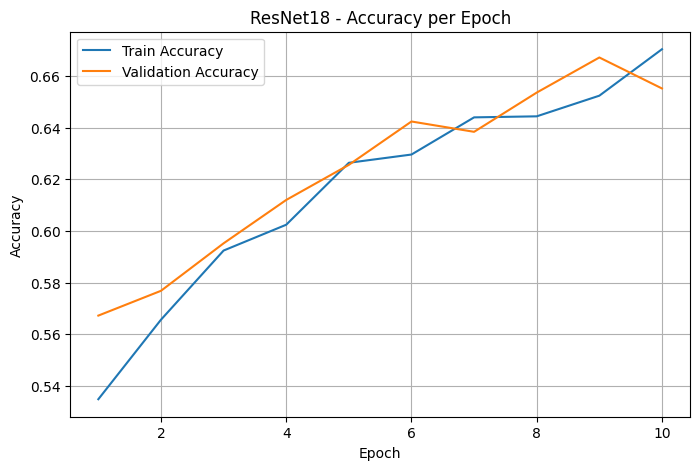

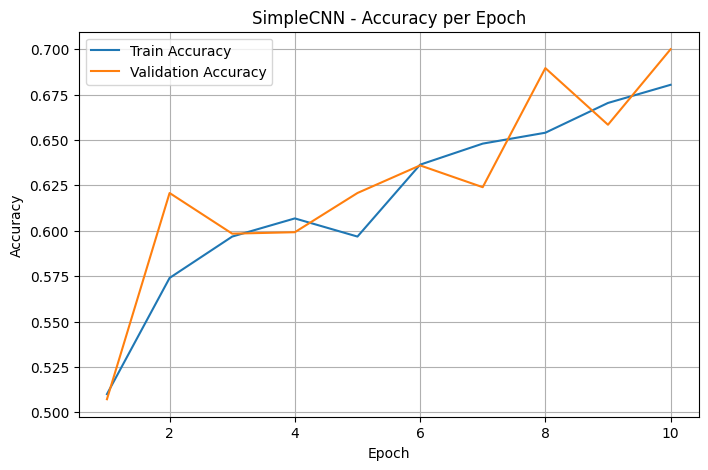

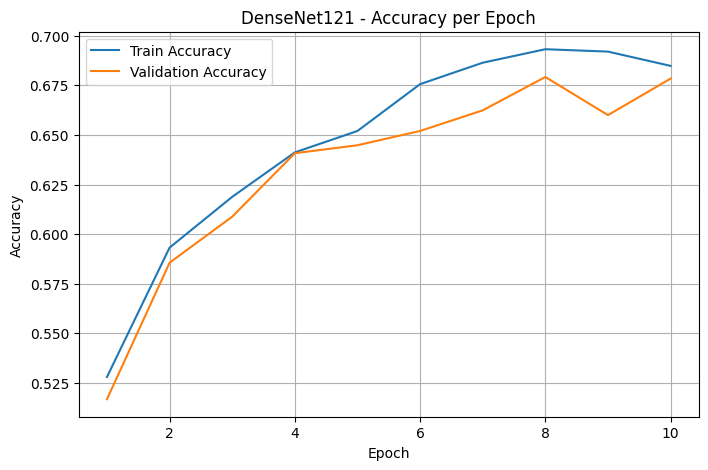

In [42]:
import matplotlib.pyplot as plt
import torch

# Function to load model histories (assumes each result contains the best model and its history)
def extract_accuracy_histories(results, model_name):
    for result in results:
        if result["combo"] == 1: 
            history = result["history"]
            return history["train_acc"], history["val_acc"]
    raise ValueError(f"No training history found for {model_name}")


# Extracting histories
vgg_train, vgg_val = extract_accuracy_histories(vgg_results, "VGG16")
resnet_train, resnet_val = extract_accuracy_histories(resnet_results, "ResNet18")
simplecnn_train, simplecnn_val = extract_accuracy_histories(results, "SimpleCNN")
densenet_train, densenet_val = extract_accuracy_histories(densenet_results, "DenseNet121")

# Plotting utility
def plot_model_accuracy(train_acc, val_acc, title):
    plt.figure(figsize=(8, 5))
    epochs = list(range(1, len(train_acc) + 1))
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot each model's training and validation accuracy
plot_model_accuracy(vgg_train, vgg_val, "VGG16")
plot_model_accuracy(resnet_train, resnet_val, "ResNet18")
plot_model_accuracy(simplecnn_train, simplecnn_val, "SimpleCNN")
plot_model_accuracy(densenet_train, densenet_val, "DenseNet121")


In [ ]:
print("Model loaded from best_vgg16.pth")

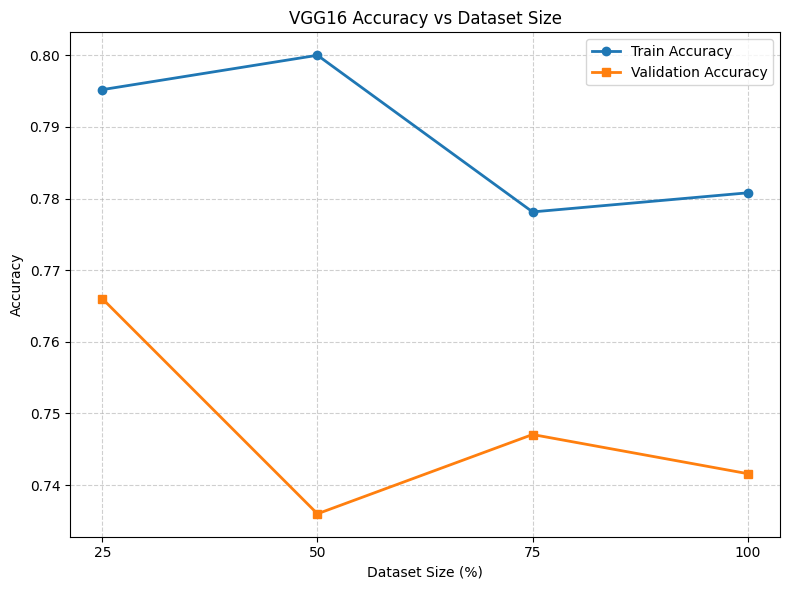

In [45]:
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Load best saved model
model = get_vgg16_model(dropout_rate=0.5)
model.load_state_dict(torch.load("best_vgg16.pth", map_location=torch.device('cpu')))
model.eval()

# Function to evaluate accuracy
def evaluate(loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            labels = labels.float().unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Define dataset fractions and results
fractions = [0.25, 0.5, 0.75, 1.0]
labels = [25, 50, 75, 100]
train_accuracies = []
val_accuracies = []

# Use fixed random seed for reproducibility
np.random.seed(42)

# Evaluate for each dataset size
for frac in fractions:
    train_subset = Subset(train_data, np.random.choice(len(train_data), int(len(train_data) * frac), replace=False))
    val_subset = Subset(val_data, np.random.choice(len(val_data), int(len(val_data) * frac), replace=False))
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    train_accuracies.append(evaluate(train_loader))
    val_accuracies.append(evaluate(val_loader))

# Create a smooth, clean plot
plt.figure(figsize=(8, 6))
plt.plot(labels, train_accuracies, label='Train Accuracy', marker='o', linewidth=2)
plt.plot(labels, val_accuracies, label='Validation Accuracy', marker='s', linewidth=2)
plt.xlabel("Dataset Size (%)")
plt.ylabel("Accuracy")
plt.title("VGG16 Accuracy vs Dataset Size")
plt.xticks(labels)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
